<h1> Fisher matrix SGWB </h1> 

In the following, we'll implement a notebook that will estimate the Fisher Matrix for a parametrization of the SGWB.
Let's start by importing some modules :

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

# Signal flags

PL2P = False

# Noise Flags

FixedNoise = False
NoiseAmp1P = False
Noise2P = False


# Merger distribution parameters

T_obs = 4. # Lisa estimated years of observation
efficiency = 1. # Lisa effective usefull time percentage for observations
max_tc = 10000. # max years of coalescence time for a BBH mergine event
frq_min = 3.e-5 # Minimum frequency in hertz to which the LISA detector is sensitive
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive
frq_star = 1.e-2 # Value of the choosen frequency at which we estimate the SGWB to compare with other results 

# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc


#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
GPc = 3.08567758149137*1e25 # meters
h = 0.678
H_0 = 67.8/(3.086e+19) # Hubble constant in 1/(s)
Omega_m = 0.3 # Matter density in our universe
Omega_lambda = 0.7 # Cosmological constant density in our universe
Omega_k = 0. # Curvature density in our universe
rho_c = (3.*(H_0**2.))/(8.*np.pi*G) # Critical density in our universe
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

frq_res = 5000

# Parameters for the multiprocessing

n_jobs = 10


<h2> FLAG selection section </h2>

To begin, we have to decide which types of signal model we wish to simulate in our SGWB :

In [3]:
# 2 Parameters model

PL2P = True # If true, it will estimate the fisher matrix for a power law where both tilt and amplitude are free parameters

in the same way, the flags for the noise model are listed below :

In [4]:
# 0 parameters model

# FixedNoise = True # If True, the noise will be considered constant and it would not be considered in the Fisher Matrix 

# 1 Parameters model

#NoiseAmp1P = True # If True, allow the noise curve to increase or decrease in amplitude as c*Sens(f)

# 2 Parameters model

Noise2P = True # If True, the standard LISA 2 parameters noise model will be used

<h2> Defining the number of parameters of the model </h2>

Each model assumes a different number of free parameters to describe the signal, this will be automatically defined as :

In [5]:
if PL2P :
    N_SigMParms = 2

in the same way, for the noise models we have :

In [6]:
if FixedNoise:
    N_NoiseMParms = 0

if NoiseAmp1P:
    N_NoiseMParms = 1

if Noise2P:
    N_NoiseMParms = 2

The total number of parameters considered in the fisher matrix are hence given by :

In [7]:
N_modparms = N_SigMParms + N_NoiseMParms

<h2> Confidence Ellipses functions </h2>

From the covariance matrix, it is possible to plot the confidence ellipses,which provide an optimistic approximation of the true probability distriutions.
In the following, we are going to define the functions needed to estimate the parameters defining this ellipses :

In [8]:
# Estimate the a parameter of the ellipse from the entries of the Covariance matrix

def ConElips_a(sigma_x, sigma_y, sigma_xy):
    res = (sigma_x + sigma_y)/2. + np.sqrt(((sigma_x - sigma_y)**2)/4. + sigma_xy**2)
    return np.sqrt(res)

In [9]:
# Estimate the b parameter of the ellipse from the entries of the Covariance matrix

def ConElips_b(sigma_x, sigma_y, sigma_xy):
    res = (sigma_x + sigma_y)/2. - np.sqrt(((sigma_x - sigma_y)**2)/4. + sigma_xy**2) 
    return np.sqrt(res)

In [10]:
# Estimate the tilt theta of the ellipse with respect to the x axis from the entries of the Covariance matrix

def ConElips_theta(sigma_x, sigma_y, sigma_xy):
    if(sigma_x != sigma_y):
        res = (2.*sigma_xy)/(sigma_x - sigma_y) 
        return 0.5*np.arctan(res)
    else:
        return np.pi/4.

Furthermore, a coefficient alpha that need to be multiplied to the parameters a and b in order to obtain the confidence levels at various sigmas.
The values of this coefficient can be found in [Dan Coe](https://arxiv.org/abs/0906.4123), and are defined in the following :

In [11]:
# these are the constants that need to multiply the parameters a and b of the ellipses to get the confidence levels
# the array, will be such as CL_alpha[1] = 1 sigma value of the constant alpha
# the values

CL_alpha = {}
CL_alpha[0] = 1.
CL_alpha[1] = 1.52 # 68.3% confidence level
CL_alpha[2] = 2.48 # 95.4% confidence level
CL_alpha[3] = 3.44 # 99.7% confidence level

<h2> Standard Cosmological Functions </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [12]:
# Just a function to convert from Z to GPC using Hubble Law, in order to obtain the comoving distance

z_max = 1.e5
z_prec = 500

def H(z):
    return np.sqrt((H_0**2.)*(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))

def Z_to_Gpc(z):
    
    # Remove the commented part to use a linear approximation of the Hubble law for low z 
    
    #if(zmax <= 0.5):
    #    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 0.5
    #else:
        
        Int_Z = 0.
        span_z = np.linspace(0.,z,z_prec)
        
        # Beware, would fail if the span z is created in logarithmic scale !
        
        for i in range(len(span_z) -1):
            mid_z = 0.5*(span_z[i] + span_z[i + 1])
            Int_Z += (((span_z[i + 1] -  span_z[i])*c*(10**(-3)))/(H(mid_z)*(3.086e+19)))
    
        return Int_Z
    
def Z_to_HubbleTime(z):
    
    Int_Z = 0.
    span_z = np.logspace(np.log10(z),np.log10(z_max),z_prec)
        
    # Beware, would fail if the span z is created in logarithmic scale !
        
    for i in range(len(span_z) -1):
        mid_z = 0.5*(span_z[i] + span_z[i + 1])
        Int_Z += (span_z[i + 1] -  span_z[i])/(H(mid_z)*(1. + mid_z))
    
    return Int_Z
    
        

we also need a function that estimates the differential comoving volume in function of the redshift :

In [13]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z, Delta_z):
    r = Z_to_Gpc(z)
    z_2 = z + 0.5*Delta_z
    z_1 = z_2 - Delta_z
    Delta_r = Z_to_Gpc(z_2) - Z_to_Gpc(z_1)
    return ((4.*np.pi*(r**2.)*Delta_r)/Delta_z)

Another recurring parameter for inspiralling events is the Chirp Mass, given the mass of the two events involved in the binary merging :

In [14]:
# Function that return the Chirp Mass of a binary merging event

def ChirpMass(m1,m2): 
   return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

together with the effective spin :

In [15]:
#Function that given the spin and spin tilt gives the effective spin

def EffectiveSpin(m1, m2, a1, a2, st_a1, st_a2):
    res = (m1*a1*cos(st_a1))/(m1 + m2) + (m2*a2*cos(st_a1))/(m1 + m2) # Hope so, better to double check

To represent the signal in units of omega, we are gonna need to convert our strain from units of _h_, _hc_, or _Flux_ to units of $\Omega_{gw}$ :

In [16]:
def h_to_Omega(ran_frq, spectrum):
    # ran_frq and spectrum need to have same shape
    return ((4*((h*np.pi)**2.)*(ran_frq**3.)*spectrum)/(3.*(H_0**2)))

In [17]:
def hc_to_Omega(ran_frq, spectrum):
    # ran_frq and spectrum need to have same shape
    return ((2*((h*np.pi)**2.)*(ran_frq**2.)*spectrum)/(3.*(H_0**2)))

In [18]:
def Flux_to_Omega(ran_frq, Flux):
    # Flux need to be a constant expressing the whole integrated flux in function of z and m
    return ((ran_frq**(2./3.))/(rho_c*(c*1e3)**3))*Flux

To conclude, we may define the energy loss during the inspiral phase, the procedure implemented is described in [P. Ajith et al.](https://arxiv.org/abs/0909.2867), even though in the LISA case we can use the assumption that all the waveforms appearing in detector, are in the pre-merger phase.
We have :

while the total spectrum in Omega given by any BH channel expressed in energy spectral density, can be generally described using :

In [19]:
def SpectralDens_to_OmegaGW(freq, F_nu):
    res = (freq/(rho_c * c**3))*F_nu

<h2> LISA sensitivity curves </h2>

In the following we are going to generate the LISA sensitivity curve, in order to compare our result with the properties of the instrument.
The shape of the sensitivity curve in units of S can be defined using the following function :

In [20]:
# return the value of the sensitivity curve S_h given the frequency

def get_SciRD(freq):
    S_2 = 3.6*10.**(-41.) #1/Hz
    S_1 = 5.76*(1. + (0.0004/freq)**2.)*10.**(-48.) # 1/(Hz*s^4)
    S_R = 1. + (freq/0.025)**2.
    S_h = (10./3.)*S_R*((S_1/(2.*np.pi*freq)**4.) + S_2)
    return S_h

in alternative, we can upgrade the LISA sensitivity curve from a file as :

In [21]:
df_nm = 'MauroSensitivityCurve.h5'
df_key = 'SciRD'
Sens_Data = pd.read_hdf(df_nm, df_key)

The sensitivity curve can now be constructed by interpolating the imported dataset :

In [22]:
Sens_Fit = interpolate.interp1d(Sens_Data['Frequency'], Sens_Data['Sensitivity'])

<h2> Signal Model Definitions </h2>

In this section we are gonna define the various signal models for which we can compute the Fisher Matrix.

<h3> 2 Parameters Power Law </h3>

In this subsection, we are going to define a 2 parameters Power Law.
This can be used to determine the fisher matrix in function of the amplitude, expressed as $10^{\alpha}$, or for the spin tilt that define the behaviour in function of frequency $f^\beta$.

In [23]:
# Return the value of the power law at a given frequency, in function of the two parameters of amplitude alpha and tilt beta

if PL2P:
    # Chiara Standard population
    Omega_fstar = 1.7784822965353423e-12 # Value taken from the value of the SGWB in Omega units for the fiducial population at frequency f_star = 1e-2
    beta = 2./3. # Known from theory
    alpha = np.log10(Omega_fstar*(np.sqrt(frq_min*frq_max)/frq_star)**(beta)) # estimating the value of alpha given the model shape
    signal_fidval = [alpha, beta]
    signal_labels = [r'$\alpha$', r'$\beta$']
    
    
    def PL_2P(alpha, beta, f):
        return (10**alpha)*((f/np.sqrt(frq_min*frq_max))**beta)

In [24]:
alpha

-12.024586700515743

The ligo upper limit can be obtained by looking at [arxiv 2101.12130](https://arxiv.org/abs/2101.12130), we obtain:

In [25]:
Omega_maxLigo = 3.4e-9
f_LIGO = 25 # Hz
LIGO_f = 5 # Hz
LIFO_F = 5000 # Hz
alpha_L = np.log10(Omega_maxLigo*(np.sqrt(frq_min*frq_max)/f_LIGO)**(beta))
print('LIGO max SGWB treshold : ',PL_2P(alpha_L, beta, frq_star))

LIGO max SGWB treshold :  1.84580397928454e-11


In [26]:
alpha_L

-11.008450669053875

To compute the fisher matrix, we also need the first derivatives in function of the parameters.
They can be computed analytically as :

In [27]:
# Return the first derivatives of the 2 parameters power law in function of the two parameters
# Index 1 derives in function of alpha, while index 2 derives in function of beta

if PL2P:
    def d1_PL2P(index, alpha, beta, f):
        if index == 1:
            # Derivative in function of alpha
            return (10**alpha)*np.log(10)*((f/np.sqrt(frq_min*frq_max))**beta)
        elif index == 2:
            # Derivative in function of beta
            return (10**alpha)*np.log(f/np.sqrt(frq_min*frq_max))*((f/np.sqrt(frq_min*frq_max))**beta)
        else:
            print('!Error!, the value of the index passed can be either 1 or 2 !')

<h2> Noise Model Definitions </h2>

In this section we are gonna define the various noise models for which we can compute the Fisher Matrix.

<h3> Only amplitude noise curve </h3>

In this subsection, we are going to define the noise curve as a 1 parameter dependant model.
The considered parameter $C$ would just be a scale factor that would either shrink or increase the amplitude of the standard LISA sensitivity curve, the form of the model is $Noise(f) = C*Sens(f)$.
We have :

In [28]:
# Return the value of the LISA sensitivity curve multiplied by a scale factor C

if NoiseAmp1P:
    sigma_noise = 0.00012034771123706508
    n_sigma = 0.
    C = 1. + n_sigma*sigma_noise # This is the sigma value of the noise in the fiducial case
    noise_labels = '$C-Factor$'
    noise_fidval = C
    
    def OnlyAmp_1P(C, f):
        return C*Sens_Fit(f)

In [29]:
# Return the first derivative of the 1 parameter only amplitude Noise model, this is simply the value of the LISA sensitivity curve at a given frequency

if NoiseAmp1P:
    def d1_OnlyAmp_1P(f):
        return Sens_Fit(f)

<h3> 2-Parameters noise curve </h3>

In this subsection, we are going to define the standard LISA 2 parameter model. The two parameters of the model will be $A$ and $P$, which are constants defining the amplitude respectively of the acceleration and interferometric noise. We can start by loading the geometrical response function from a file :

In [30]:
GeomRf = pd.read_pickle('geometrical.pkl')

the file has the following enetries:

In [31]:
# We need to use 2 * Geom AA + Geom_TT
GeomRf

,frequency,geometrical_XX,geometrical_XY,geometrical_AA,geometrical_TT
0,0.000030,0.300021,-0.149989,0.450076,3.740983e-21
1,0.000031,0.300021,-0.149988,0.450075,4.554364e-21
2,0.000032,0.300020,-0.149988,0.450073,5.510066e-21
3,0.000033,0.300019,-0.149988,0.450072,6.627351e-21
4,0.000034,0.300018,-0.149987,0.450071,7.927372e-21
...,...,...,...,...,...
499966,0.499996,0.000949,-0.000126,0.001074,6.976220e-04
499967,0.499997,0.000949,-0.000126,0.001074,6.976693e-04
499968,0.499998,0.000949,-0.000126,0.001074,6.977167e-04
499969,0.499999,0.000949,-0.000126,0.001074,6.977640e-04


as we will need to use the geometrical_AA and geometrical_TT in function of frequency, we need to create an interpolator for them both :

In [32]:
G_Raa = interpolate.interp1d(GeomRf['frequency'], GeomRf['geometrical_AA'])
G_Rtt = interpolate.interp1d(GeomRf['frequency'], GeomRf['geometrical_TT'])

We can finally define the noise of the 2-parameters model:

In [33]:
# Return the standard LISA 2-parameters noise function

if Noise2P:
    L = 2.5*1e9 # Lenght of the LISA arms in meters
    A = 3.  # Parameter for the accelleration noise, the value has a 25% error
    P = 15. # Parameter for the interferometric noise, the value has a 25% error
    noise_fidval = [A, P]
    noise_labels = [r'$A$', r'$P$']
    
    # Defining the Acceleration noise term as:
    
    def P_acc(f, A):
        ris = (A**2.)*(1.e-30)*(1. + ((4*1.e-4)/(f))**2.)*(1. + ((f)/(8.*1.e-3))**4.)*((1./(2*np.pi*f))**4.)*((2*np.pi*f)/(c*1000))**2.
        return ris
    
    # Defining the Interferometric noise term as:
    
    def P_IMS(f,P):
        ris = (P**2.)*(1.e-24)*(1. + ((2*1.e-3)/(f))**4.)*((2*np.pi*f)/(c*1000))**2.
        return ris
    
    # They are matched together as:
    
    def P_PSD(f, A, P, channel):
        if channel == 'AA':
            ris = 8.*(np.sin((2.*np.pi*f*L)/(c*1000))**2.)*(4*(1 + np.cos((2.*np.pi*f*L)/(c*1000)) \
                + (np.cos((2.*np.pi*f*L)/(c*1000))**2.))*P_acc(f, A) + (2. + np.cos((2.*np.pi*f*L)/(c*1000)))*P_IMS(f,P))            
        if channel == 'TT':
            ris = 16.*(np.sin((2.*np.pi*f*L)/(c*1000))**2.)*(2.*((1. - np.cos((2.*np.pi*f*L)/(c*1000)))**2.)*P_acc(f, A)\
                + (1. - np.cos((2.*np.pi*f*L)/(c*1000)))*P_IMS(f,P)) 
        return ris
     
    def Resp(f, channel):
        ris = 16.*(np.sin((2.*np.pi*f*L)/(c*1000))**2.)*((2.*np.pi*f*L)/(c*1000))**2.
        if channel == 'AA':
            ris *= G_Raa(f)            
        if channel == 'TT':
            ris *= G_Rtt(f) 
        return ris
    
    # The total noise strain is given by:
    
    def S_n(f,A,P, channel):
        ris = (P_PSD(f, A, P, channel))/(Resp(f, channel))
        return ris
    
    # Which in Omega units is given by:
    
    def NoiseSens_2P(f, A, P, channel):
        ris = ((4*(np.pi**2.)*(f**3.))/(3.*(H_0/h)**2.))*S_n(f, A, P, channel)
        return ris

In [34]:
# Return the first derivative of the 2 parameter standard LISA Noise model
# Index 1 derives in function of A, while index 2 derives in function of P

if Noise2P:
    # We need some auxiliary functions in order to estimate the derivatives
    
    def dP_acc(f, A):
                ris = (2.*A)*(1.e-30)*(1. + ((4*1.e-4)/(f))**2.)*(1. + ((f)/(8.*1.e-3))**4.)*((1./(2*np.pi*f))**4.)*((2*np.pi*f)/(c*1000))**2.
                return ris
    
    def dP_IMS(f,P):
        ris = (2.*P)*(1.e-24)*(1. + ((2*1.e-3)/(f))**4.)*((2*np.pi*f)/(c*1000))**2.
        return ris
    
    def dP_PSD(index, f, A, P, channel):
        if index == 1:
            # Derivative in function of A
            if channel == 'AA':
                ris = 8.*(np.sin((2.*np.pi*f*L)/(c*1000))**2.)* (4*(1 + np.cos((2.*np.pi*f*L)/(c*1000)) \
                    + (np.cos((2.*np.pi*f*L)/(c*1000))**2.)))*dP_acc(f, A)
            if channel == 'TT':
                ris =  16.*(np.sin((2.*np.pi*f*L)/(c*1000))**2.)*(2.*((1. - np.cos((2.*np.pi*f*L)/(c*1000)))**2.)*dP_acc(f, A)) 
            return ris
        elif index == 2:
            # Derivative in function of P
            if channel == 'AA':
                ris = 8.*(np.sin((2.*np.pi*f*L)/(c*1000))**2.)*(2. + np.cos((2.*np.pi*f*L)/(c*1000)))*dP_IMS(f,P)           
            if channel == 'TT':
                ris = 16.*(np.sin((2.*np.pi*f*L)/(c*1000))**2.)*(1. - np.cos((2.*np.pi*f*L)/(c*1000)))*dP_IMS(f,P)  
            return ris
        else:
            print('!Error!, the value of the index passed can be either 1 or 2 !')
            
    def d1_NS2P(index, f, A, P, channel):
        ris = (dP_PSD(index,f,A,P, channel))/(Resp(f, channel))
        return ((4*(np.pi**2.)*(f**3.))/(3.*(H_0/h)**2.))*ris

<h2> Function to estimate the Fisher Matrix </h2>

We will now define a function in order to estimate the Fisher Matrix Entries.
The main purpose of this function is to check the various flags of the simulation in order to decide which models need to be used in the estimation of the Fisher Matrix

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [35]:
# Inizialization of the frequency range and spectrum

ran_frq = np.linspace(frq_min, frq_max, frq_res)
#ran_frq = np.logspace(np.log10(frq_min), np.log10(frq_max), frq_res)
ran_mfrq = (ran_frq[:-1] + ran_frq[1:])*0.5
ran_df = (ran_frq[1:] - ran_frq[:-1])
Sensitivity = get_SciRD(ran_mfrq)


<h2> Estimation of the Fisher Matrix entries </h2>

Let's start by initializing the Fisher Matrix and the Data Stream in function of the frequency.

In [36]:
Fisher = np.zeros((N_modparms, N_modparms))
if Noise2P:
    Data_AA = ran_mfrq*0.
    Data_TT = ran_mfrq*0.
else:
    Data = ran_mfrq*0.
fid_val = {}
d1 = {}
labels = {}

We can now proceed by first adding the right noise curve to the data stream :

In [37]:
#Adding the right noise curve

if FixedNoise:
    Data += h_to_Omega(ran_mfrq, Sensitivity)
    
    
if NoiseAmp1P:
    Data += OnlyAmp_1P(C, ran_mfrq)
    fid_val[N_SigMParms] = noise_fidval
    d1[N_SigMParms] = d1_OnlyAmp_1P(ran_mfrq)
    labels[N_SigMParms] = noise_labels

if Noise2P:
    Data_AA += NoiseSens_2P(ran_mfrq, A, P, 'AA')
    Data_TT += NoiseSens_2P(ran_mfrq, A, P, 'TT')
    for i in range(N_NoiseMParms):
        fid_val[N_SigMParms + i] = noise_fidval[i]
        labels[N_SigMParms + i] = noise_labels[i]
        d1[N_SigMParms + i]= {'AA' : d1_NS2P(i + 1, ran_mfrq, A, P, 'AA'), 'TT' : d1_NS2P(i + 1, ran_mfrq, A, P, 'TT')}
        

and then adding the choosen signal model to our Data Stream :

In [38]:
# Adding the right signal model

if PL2P:
    if Noise2P:
        Data_AA += PL_2P(alpha, beta, ran_mfrq)
        Data_TT += PL_2P(alpha, beta, ran_mfrq)
    else:
        Data += PL_2P(alpha, beta, ran_mfrq)
    for i in range(N_SigMParms):
        fid_val[i] = signal_fidval[i]
        d1[i] = d1_PL2P(i + 1, alpha, beta, ran_mfrq)
        labels[i] = signal_labels[i]

We may finally estimate the Fisher matrix in function of the given parameters !
This can be done as follows :

In [39]:
# We can fill the values of the Fisher Matrix as :
    
for i in range(N_modparms):
    for j in range(N_modparms):
        if Noise2P:
            # In this case we estimate the fisher matrix using two channels for the detector
            if (i >= N_SigMParms) and (j >= N_SigMParms):
                Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*((2*d1[i]['AA']*d1[j]['AA']/(Data_AA**2.)) + (d1[i]['TT']*d1[j]['TT']/(Data_TT**2.))))
            elif (i >= N_SigMParms):
                Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*((2*d1[i]['AA']*d1[j]/(Data_AA**2.)) + (d1[i]['TT']*d1[j]/(Data_TT**2.))))
            elif (j >= N_SigMParms):
                Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*((2*d1[i]*d1[j]['AA']/(Data_AA**2.)) + (d1[i]*d1[j]['TT']/(Data_TT**2.))))
            else:
                Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*((2*d1[i]*d1[j]/(Data_AA**2.)) + (d1[i]*d1[j]/(Data_TT**2.))))
        else:
            Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*d1[i]*d1[j]/(Data**2.))

We obtain the following Fisher Matrix for the considered case :

In [40]:
print(Fisher)


[[ 2.31130606e+04 -8.58577634e+02  4.70221645e+04  2.12396953e+04]
 [-8.58577634e+02  9.11971546e+02 -8.29831470e+03  4.50699145e+03]
 [ 4.70221645e+04 -8.29831470e+03  2.54764017e+05  2.83728768e+05]
 [ 2.12396953e+04  4.50699145e+03  2.83728768e+05  3.23863351e+06]]


<h2> Estimation of the Covariance Matrix </h2>

Given the Fisher Matrix, we can easily obtain the Covariance matrix as the inverse of the first:

In [41]:
Covariance = np.linalg.inv(Fisher)
print(np.linalg.cond(Fisher))

6205.80881156257


we obtain the following Covariance Matrix : 

In [42]:
print(Covariance)

[[ 7.72876746e-05 -1.09769104e-04 -1.93324088e-05  1.33955333e-06]
 [-1.09769104e-04  1.88901236e-03  9.29888802e-05 -1.00554511e-05]
 [-1.93324088e-05  9.29888802e-05  1.16631655e-05 -1.02440155e-06]
 [ 1.33955333e-06 -1.00554511e-05 -1.02440155e-06  4.03725928e-07]]


<h2> Plotting the results </h2>

We can proceed to plot our results!
However, let's first run this additional script that would increase the standard font size for the plots :

In [43]:
%run BigFont.py 

First of all, we can compare our sensitivity curve for the model with the standard LISA sensitivity curve SciRD :

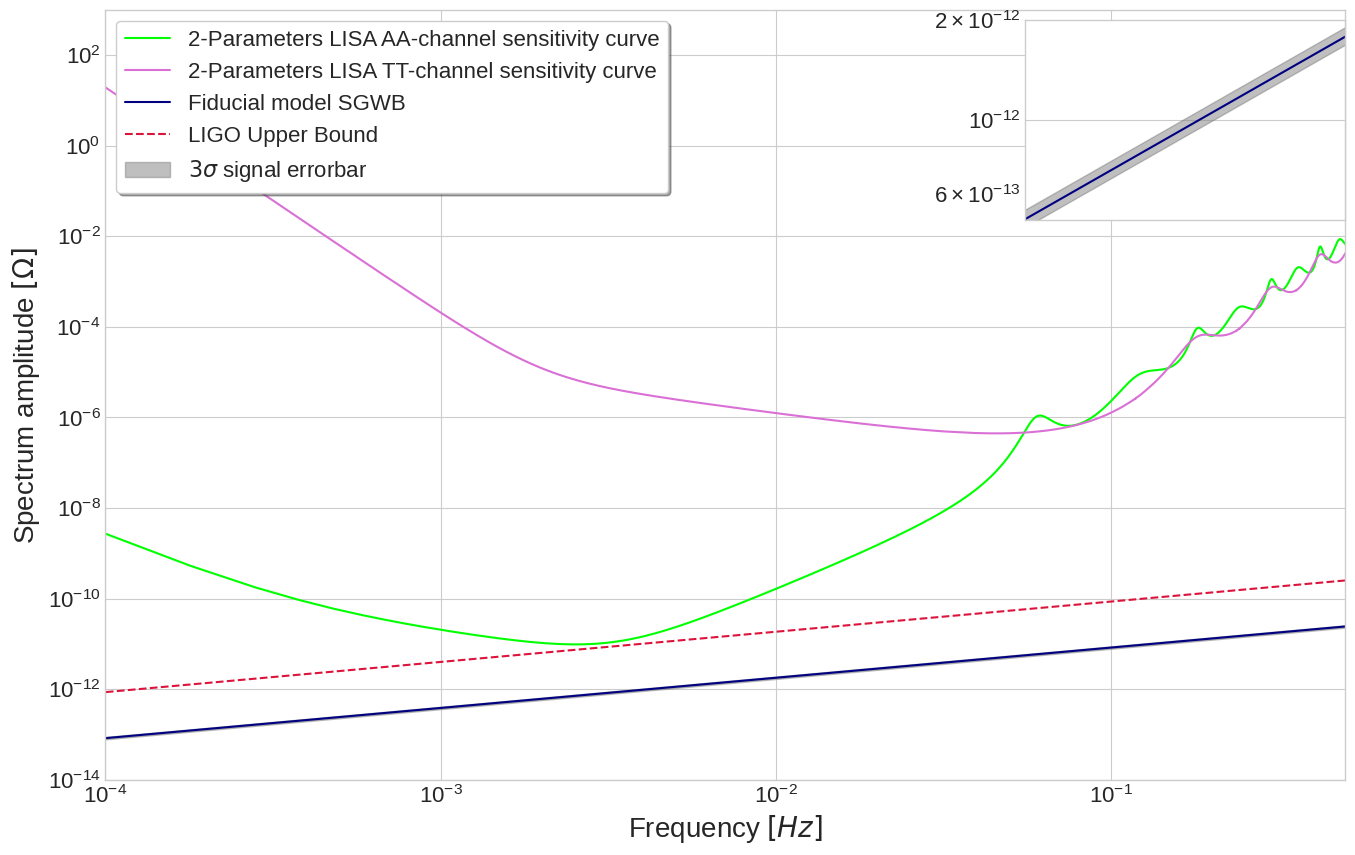

In [44]:
plt.figure(figsize=(16,10))
ax1 = plt.axes()  # standard axes
ax1.set_ylim(1.e-14, 1.e3)
ax1.set_xlim(1.e-4, 0.5)
ax2 = plt.axes([0.7, 0.67, 0.2, 0.2])
ax2.set_ylim(0.5e-12, 2.e-12)
ax2.set_xlim(1.5e-3, 1.e-2)
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
if FixedNoise:
    ax1.loglog(ran_mfrq, h_to_Omega(ran_mfrq, Sensitivity), color  = 'black', label = 'LISA standard SciRD sensitivity curve')
if NoiseAmp1P:
    ax1.loglog(ran_mfrq, Sens_Fit(ran_mfrq), color = 'gold', label = 'Imported sensitivity curve')
if Noise2P:
    ax1.loglog(ran_mfrq, NoiseSens_2P(ran_mfrq, A, P, 'AA'), color = 'lime', label = '2-Parameters LISA AA-channel sensitivity curve')
    ax1.loglog(ran_mfrq, NoiseSens_2P(ran_mfrq, A, P, 'TT'), color = 'orchid', label = '2-Parameters LISA TT-channel sensitivity curve')
if PL_2P:
    ax1.loglog(ran_mfrq,PL_2P(alpha, beta, ran_mfrq), color = 'navy', label = 'Fiducial model SGWB')
    ax1.loglog(ran_mfrq,PL_2P(alpha_L, beta, ran_mfrq), color = 'crimson', ls = 'dashed', label = 'LIGO Upper Bound')
    ax1.fill_between(ran_mfrq, PL_2P(alpha - 3.*np.sqrt(Covariance[0][0]), beta,ran_mfrq), PL_2P(alpha + 3.*np.sqrt(Covariance[0][0]), beta,ran_mfrq),color='gray', alpha=0.5, label = r'$3\sigma$ signal errorbar')
    ax2.loglog(ran_mfrq,PL_2P(alpha, beta, ran_mfrq), color = 'navy', label = 'Fiducial model SGWB')
    ax2.fill_between(ran_mfrq, PL_2P(alpha - 3.*np.sqrt(Covariance[0][0]), beta,ran_mfrq), PL_2P(alpha + 3.*np.sqrt(Covariance[0][0]), beta,ran_mfrq),color='gray', alpha=0.5, label = r'$3\sigma$ signal errorbar')
ax1.set_xlabel(r'Frequency $[Hz]$', fontsize = 20 )
ax1.legend(loc = 2, frameon = True, fancybox = True, shadow = True)
ax1.set_ylabel(r'Spectrum amplitude $[\Omega]$', fontsize = 20)
#plt.savefig('SGWB&Sensitivity_curves.png',dpi=500)
plt.savefig('SGWB&Sensitivity_curves.png',dpi=50)

To plot the confidence ellipses, we are going to create a matrix of subplots as follows :

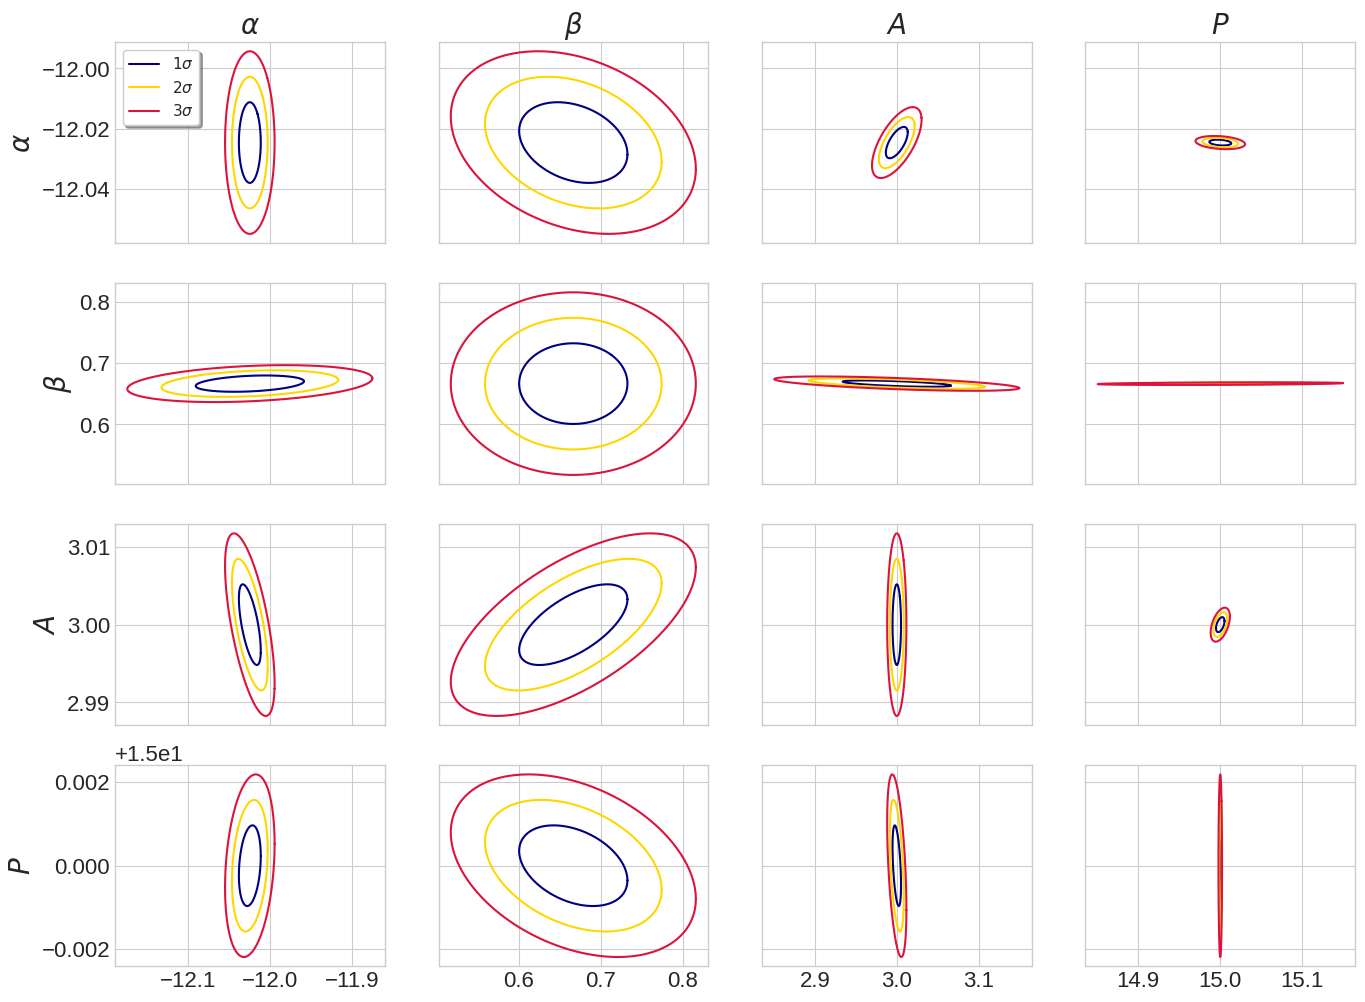

In [45]:
#Need a span over the total angle to plot the ellipses

t = np.linspace(0, 2*np.pi, 10000)

fig, ax = plt.subplots(N_modparms, N_modparms, figsize=(16,12), sharex='col', sharey='row')

for i in range(N_modparms):
    for j in range(N_modparms):
        
        if j == 0:
            ax[i, j].set_ylabel(labels[i], fontsize = 20)
            
        #Writing the label on the x axis
            
        if i == 0:
            ax[i, j].set_title(labels[j], fontsize = 20)
        
        # We can now estimate the coefficients of the ellipses to be printed
        
        u = fid_val[j]    #x-position of the center
        v = fid_val[i]    #y-position of the center
        
        if (i!=j):
            a = ConElips_a(Covariance[j][j], Covariance[i][i] , Covariance[j][i])         #radius on the x-axis
            b = ConElips_b(Covariance[j][j], Covariance[i][i] , Covariance[j][i])         #radius on the y-Caxis
            t_rot = ConElips_theta(Covariance[j][j], Covariance[i][i] , Covariance[j][i]) #rotation angle  
        else:
            a = ConElips_a(Covariance[j][j], Covariance[i][i] , 0.)         #radius on the x-axis
            b = ConElips_b(Covariance[j][j], Covariance[i][i] , 0.)         #radius on the y-axis
            t_rot = ConElips_theta(Covariance[j][j], Covariance[i][i] , 0.) #rotation angle

        # The ellipses at the various confidence levels can instead be estimated as follows
        
        #print('for i = ',i,' and j = ',j,' we have a = ',a,', b = ',b,', and theta =',t_rot)
        
        Ell_1sig = np.array([a*CL_alpha[1]*np.cos(t) , b*CL_alpha[1]*np.sin(t)])
        Ell_2sig = np.array([a*CL_alpha[2]*np.cos(t) , b*CL_alpha[2]*np.sin(t)])
        Ell_3sig = np.array([a*CL_alpha[3]*np.cos(t) , b*CL_alpha[3]*np.sin(t)])
        
        # The rotation matrix can be defined as follows
        
        R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])  
        
        # We can now initialize new arrays in order to calculate the rotated ellipses
        
        RotEll_1sig = np.zeros((2,Ell_1sig.shape[1]))
        RotEll_2sig = np.zeros((2,Ell_2sig.shape[1]))
        RotEll_3sig = np.zeros((2,Ell_3sig.shape[1]))
        
        # The rotated ellipses are now obtained by a simple dot product
        
        for k in range(Ell_1sig.shape[1]):
            RotEll_1sig[:,k] = np.dot(R_rot,Ell_1sig[:,k])
            RotEll_2sig[:,k] = np.dot(R_rot,Ell_2sig[:,k])
            RotEll_3sig[:,k] = np.dot(R_rot,Ell_3sig[:,k])
        
        # Finally we can plot our confidence ellipses
        
        
        
        ax[i, j].plot( u + RotEll_1sig[0,:] , v + RotEll_1sig[1,:], color = 'navy', label = r'$1\sigma$')
        ax[i, j].plot( u + RotEll_2sig[0,:] , v + RotEll_2sig[1,:], color = 'gold', label = r'$2\sigma$')
        ax[i, j].plot( u + RotEll_3sig[0,:] , v + RotEll_3sig[1,:], color = 'crimson', label = r'$3\sigma$')
        
        if (i == 0 and j ==0):
            ax[i, j].legend(loc = 2, frameon = True, fancybox = True, shadow = True, prop={'size': 11})       

fig.savefig('ConfidenceEllipses.png', dpi = 300)

If we wish to analyze any subplot in particular, we just have to change the i,j, in the following let's try to analize in detail the top left plot :

Text(0, 0.5, '$\\alpha$')

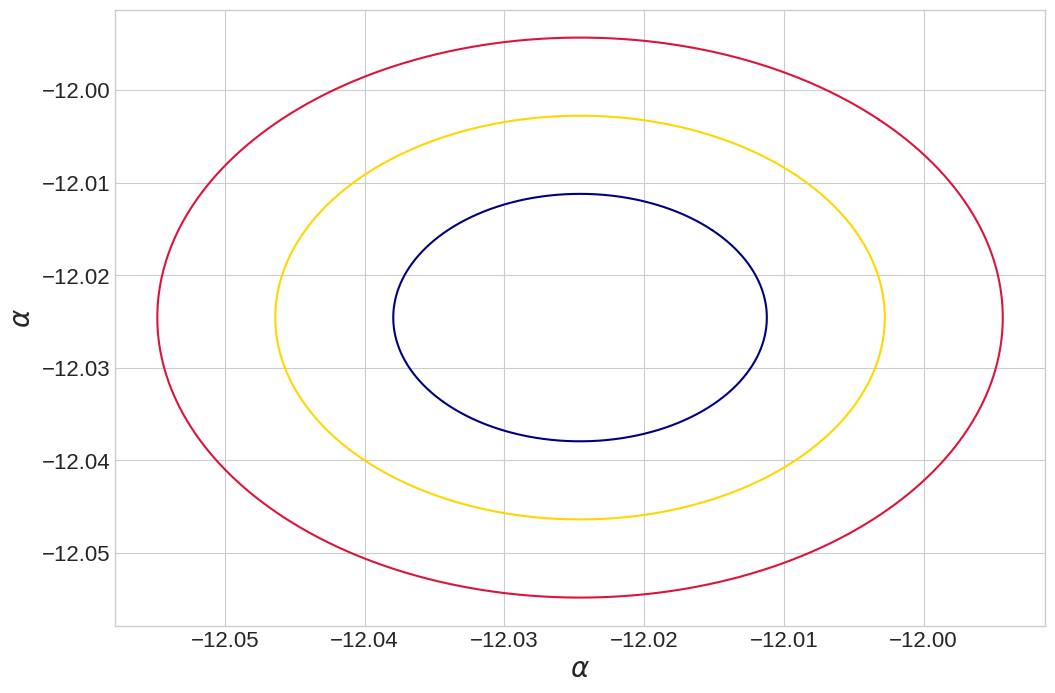

In [46]:
        i = 0
        j = 0
        u = fid_val[j]                                                                #x-position of the center
        v = fid_val[i]                                                                #y-position of the center
        
        if (i!=j):
            a = ConElips_a(Covariance[j][j], Covariance[i][i] , Covariance[i][j])         #radius on the x-axis
            b = ConElips_b(Covariance[j][j], Covariance[i][i] , Covariance[i][j])         #radius on the y-axis
            t_rot = ConElips_theta(Covariance[j][j], Covariance[i][i] , Covariance[i][j]) #rotation angle
        else:
            a = ConElips_a(Covariance[j][j], Covariance[i][i] , 0.)         #radius on the x-axis
            b = ConElips_b(Covariance[j][j], Covariance[i][i] , 0.)         #radius on the y-axis
            t_rot = ConElips_theta(Covariance[j][j], Covariance[i][i] , 0.) #rotation angle

        # The ellipses at the various confidence levels can instead be estimated as follows
        
        Ell_1sig = np.array([a*CL_alpha[1]*np.cos(t) , b*CL_alpha[1]*np.sin(t)])
        Ell_2sig = np.array([a*CL_alpha[2]*np.cos(t) , b*CL_alpha[2]*np.sin(t)])
        Ell_3sig = np.array([a*CL_alpha[3]*np.cos(t) , b*CL_alpha[3]*np.sin(t)])
        
        # The rotation matrix can be defined as follows
        
        R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])  
        
        # We can now initialize new arrays in order to calculate the rotated ellipses
        
        RotEll_1sig = np.zeros((2,Ell_1sig.shape[1]))
        RotEll_2sig = np.zeros((2,Ell_2sig.shape[1]))
        RotEll_3sig = np.zeros((2,Ell_3sig.shape[1]))
        
        # The rotated ellipses are now obtained by a simple dot product
        
        for k in range(Ell_1sig.shape[1]):
            RotEll_1sig[:,k] = np.dot(R_rot,Ell_1sig[:,k])
            RotEll_2sig[:,k] = np.dot(R_rot,Ell_2sig[:,k])
            RotEll_3sig[:,k] = np.dot(R_rot,Ell_3sig[:,k])
        
        # Finally we can plot our confidence ellipses
        
        plt.figure(figsize=(12,8))
        plt.plot( u + RotEll_1sig[0,:] , v + RotEll_1sig[1,:], color = 'navy', label = r'$1-\sigma$'+' confidential region' )
        plt.plot( u + RotEll_2sig[0,:] , v + RotEll_2sig[1,:], color = 'gold', label = r'$2-\sigma$'+' confidential region' )
        plt.plot( u + RotEll_3sig[0,:] , v + RotEll_3sig[1,:], color = 'crimson', label = r'$3-\sigma$'+' confidential region' )
        plt.xlabel(labels[j], fontsize = 20)
        plt.ylabel(labels[i], fontsize = 20)

We can find the maximum value that the parameter $\alpha$ can reach before being outside the $\sigma$ zones as:

In [47]:
sigma_alpha = max(RotEll_2sig[1,:]) - max(RotEll_1sig[1,:]) 
alpha_1sig = u + max(RotEll_1sig[1,:])
alpha_2sig = u + max(RotEll_2sig[1,:])
alpha_3sig = u + max(RotEll_3sig[1,:])
print('The maximum value in the parameter allowed before being outside the 1\u03C3 zone is : ' + str(alpha_1sig))
print('The maximum value in the parameter allowed before being outside the 2\u03C3 zone is : ' + str(alpha_2sig))
print('The maximum value in the parameter allowed before being outside the 3\u03C3 zone is : ' + str(alpha_3sig))

The maximum value in the parameter allowed before being outside the 1σ zone is : -12.011223862410317
The maximum value in the parameter allowed before being outside the 2σ zone is : -12.002784175185836
The maximum value in the parameter allowed before being outside the 3σ zone is : -11.994344487961357


In [48]:
sigma_alpha

0.008439687224479821

which, at the choosen value of $f^*$ give the following values for the amplitude of the SGWB :

In [49]:
print('The fiducial estimated value of the SGWB at frequency ',frq_star,' is : ',PL_2P(alpha, beta, frq_star))
print('The estimated value of the 1\u03C3 SGWB at frequency ',frq_star,' is : ',PL_2P(alpha_1sig, beta, frq_star))
print('The estimated value of the 2\u03C3 SGWB at frequency ',frq_star,' is : ',PL_2P(alpha_2sig, beta, frq_star))
print('The estimated value of the 3\u03C3 SGWB at frequency ',frq_star,' is : ',PL_2P(alpha_3sig, beta, frq_star))

The fiducial estimated value of the SGWB at frequency  0.01  is :  1.7784822965353431e-12
The estimated value of the 1σ SGWB at frequency  0.01  is :  1.8340551238794126e-12
The estimated value of the 2σ SGWB at frequency  0.01  is :  1.8700450622127026e-12
The estimated value of the 3σ SGWB at frequency  0.01  is :  1.9067412364951496e-12


We hence have:

In [50]:
OmegaGW_1sig = 1.8340551238794126e-12
OmegaGW_2sig = 1.8700450622127026e-12
OmegaGW_3sig = 1.9067412364951496e-12

<h2> Looking for the minimum values of SGWB amplitude to be above the fiducial $\bf N-\bf \sigma$ region </h2>

We now have to find for which level of SGWB amplitude our results will be above the $\sigma_\alpha$ estimated in the previous section. To this extent, we can rerun the previouslyperformed analysis with a span of different values for the initial SGWB amplitude and find at which values the overtake will happen. The SGWB amplitude range will be set in the region:

In [51]:
ran_OmegaGW = np.linspace(1.9e-12, 2.2e-12, 2000)

The analysis can be rerun by doing:

In [52]:
print_1sig = True
print_2sig = True
print_3sig = True

for indx in range(len(ran_OmegaGW)):
    Omega_fstar = ran_OmegaGW[indx]
    alpha = np.log10(Omega_fstar*(np.sqrt(frq_min*frq_max)/frq_star)**(beta)) # estimating the value of alpha given the model shape
    signal_fidval = [alpha, beta]
    signal_labels = [r'$\alpha$', r'$\beta$']
    
    # Resetting the phase space 
    

    ran_frq = np.linspace(frq_min, frq_max, frq_res)
    #ran_frq = np.logspace(np.log10(frq_min), np.log10(frq_max), frq_res)
    ran_mfrq = (ran_frq[:-1] + ran_frq[1:])*0.5
    ran_df = (ran_frq[1:] - ran_frq[:-1])
    Sensitivity = get_SciRD(ran_mfrq)

    #computing the Fisher Matrix
    
    Fisher = np.zeros((N_modparms, N_modparms))
    if Noise2P:
        Data_AA = ran_mfrq*0.
        Data_TT = ran_mfrq*0.
    else:
        Data = ran_mfrq*0.

    fid_val = {}
    d1 = {}
    labels = {}
    
    # Adding the noise
    
    #Adding the right noise curve

    if FixedNoise:
        Data += h_to_Omega(ran_mfrq, Sensitivity)


    if NoiseAmp1P:
        Data += OnlyAmp_1P(C, ran_mfrq)
        fid_val[N_SigMParms] = noise_fidval
        d1[N_SigMParms] = d1_OnlyAmp_1P(ran_mfrq)
        labels[N_SigMParms] = noise_labels

    if Noise2P:
        Data_AA += NoiseSens_2P(ran_mfrq, A, P, 'AA')
        Data_TT += NoiseSens_2P(ran_mfrq, A, P, 'TT')
        for i in range(N_NoiseMParms):
            fid_val[N_SigMParms + i] = noise_fidval[i]
            labels[N_SigMParms + i] = noise_labels[i]
            d1[N_SigMParms + i]= {'AA' : d1_NS2P(i + 1, ran_mfrq, A, P, 'AA'), 'TT' : d1_NS2P(i + 1, ran_mfrq, A, P, 'TT')}
            
    # Adding the signal
    
    # Adding the right signal model

    if PL2P:
        if Noise2P:
            Data_AA += PL_2P(alpha, beta, ran_mfrq)
            Data_TT += PL_2P(alpha, beta, ran_mfrq)
        else:
            Data += PL_2P(alpha, beta, ran_mfrq)
        for i in range(N_SigMParms):
            fid_val[i] = signal_fidval[i]
            d1[i] = d1_PL2P(i + 1, alpha, beta, ran_mfrq)
            labels[i] = signal_labels[i]

    # We can fill the values of the Fisher Matrix as :
    
    for i in range(N_modparms):
        for j in range(N_modparms):
            if Noise2P:
                # In this case we estimate the fisher matrix using two channels for the detector
                if (i >= N_SigMParms) and (j >= N_SigMParms):
                    Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*((2*d1[i]['AA']*d1[j]['AA']/(Data_AA**2.)) + (d1[i]['TT']*d1[j]['TT']/(Data_TT**2.))))
                elif (i >= N_SigMParms):
                    Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*((2*d1[i]['AA']*d1[j]/(Data_AA**2.)) + (d1[i]['TT']*d1[j]/(Data_TT**2.))))
                elif (j >= N_SigMParms):
                    Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*((2*d1[i]*d1[j]['AA']/(Data_AA**2.)) + (d1[i]*d1[j]['TT']/(Data_TT**2.))))
                else:
                    Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*((2*d1[i]*d1[j]/(Data_AA**2.)) + (d1[i]*d1[j]/(Data_TT**2.))))
            else:
                Fisher[i][j] = np.sum(ran_df*T_obs*efficiency*year*d1[i]*d1[j]/(Data**2.))
                
    # The covariance is given by
    
    Covariance = np.linalg.inv(Fisher)
    
    # The confidence ellipses are given by
    
    t = np.linspace(0, 2*np.pi, 10000)

    for i in range(N_modparms):
        for j in range(N_modparms):

            # We can now estimate the coefficients of the ellipses to be printed

            u = fid_val[j]    #x-position of the center
            v = fid_val[i]    #y-position of the center

            if (i!=j):
                a = ConElips_a(Covariance[j][j], Covariance[i][i] , Covariance[j][i])         #radius on the x-axis
                b = ConElips_b(Covariance[j][j], Covariance[i][i] , Covariance[j][i])         #radius on the y-Caxis
                t_rot = ConElips_theta(Covariance[j][j], Covariance[i][i] , Covariance[j][i]) #rotation angle  
            else:
                a = ConElips_a(Covariance[j][j], Covariance[i][i] , 0.)         #radius on the x-axis
                b = ConElips_b(Covariance[j][j], Covariance[i][i] , 0.)         #radius on the y-axis
                t_rot = ConElips_theta(Covariance[j][j], Covariance[i][i] , 0.) #rotation angle

            # The ellipses at the various confidence levels can instead be estimated as follows

            #print('for i = ',i,' and j = ',j,' we have a = ',a,', b = ',b,', and theta =',t_rot)

            Ell_1sig = np.array([a*CL_alpha[1]*np.cos(t) , b*CL_alpha[1]*np.sin(t)])
            Ell_2sig = np.array([a*CL_alpha[2]*np.cos(t) , b*CL_alpha[2]*np.sin(t)])
            Ell_3sig = np.array([a*CL_alpha[3]*np.cos(t) , b*CL_alpha[3]*np.sin(t)])

            # The rotation matrix can be defined as follows

            R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])  

            # We can now initialize new arrays in order to calculate the rotated ellipses

            RotEll_1sig = np.zeros((2,Ell_1sig.shape[1]))
            RotEll_2sig = np.zeros((2,Ell_2sig.shape[1]))
            RotEll_3sig = np.zeros((2,Ell_3sig.shape[1]))

            # The rotated ellipses are now obtained by a simple dot product

            for k in range(Ell_1sig.shape[1]):
                RotEll_1sig[:,k] = np.dot(R_rot,Ell_1sig[:,k])
                RotEll_2sig[:,k] = np.dot(R_rot,Ell_2sig[:,k])
                RotEll_3sig[:,k] = np.dot(R_rot,Ell_3sig[:,k])       

    
    # We compute the confidence ellipse for alpha
    
    i = 0
    j = 0
    u = fid_val[j]                                                                #x-position of the center
    v = fid_val[i]                                                                #y-position of the center
        
    a = ConElips_a(Covariance[j][j], Covariance[i][i] , 0.)         #radius on the x-axis
    b = ConElips_b(Covariance[j][j], Covariance[i][i] , 0.)         #radius on the y-axis
    t_rot = ConElips_theta(Covariance[j][j], Covariance[i][i] , 0.) #rotation angle

    # The ellipses at the various confidence levels can instead be estimated as follows
        
    Ell_1sig = np.array([a*CL_alpha[1]*np.cos(t) , b*CL_alpha[1]*np.sin(t)])
    Ell_2sig = np.array([a*CL_alpha[2]*np.cos(t) , b*CL_alpha[2]*np.sin(t)])
    Ell_3sig = np.array([a*CL_alpha[3]*np.cos(t) , b*CL_alpha[3]*np.sin(t)])
        
    # The rotation matrix can be defined as follows
        
    R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])  
        
    # We can now initialize new arrays in order to calculate the rotated ellipses
        
    RotEll_1sig = np.zeros((2,Ell_1sig.shape[1]))
    RotEll_2sig = np.zeros((2,Ell_2sig.shape[1]))
    RotEll_3sig = np.zeros((2,Ell_3sig.shape[1]))
        
    # The rotated ellipses are now obtained by a simple dot product
        
    for k in range(Ell_1sig.shape[1]):
        RotEll_1sig[:,k] = np.dot(R_rot,Ell_1sig[:,k])
        RotEll_2sig[:,k] = np.dot(R_rot,Ell_2sig[:,k])
        RotEll_3sig[:,k] = np.dot(R_rot,Ell_3sig[:,k])
    
    alpha_m3sig = u - max(RotEll_3sig[1,:])
    
    if ((PL_2P(alpha_m3sig, beta, frq_star)> OmegaGW_1sig) and print_1sig):
        print('Value bigger than the 1sig at idx ',indx,' with OmegaGW = ', ran_OmegaGW[indx])
        print_1sig = False
    
    if ((PL_2P(alpha_m3sig, beta, frq_star)> OmegaGW_2sig) and print_2sig):
        print('Value bigger than the 2sig at idx ',indx,' with OmegaGW = ', ran_OmegaGW[indx])
        print_2sig = False
        
    if ((PL_2P(alpha_m3sig, beta, frq_star)> OmegaGW_3sig) and print_3sig):
        print('Value bigger than the 3sig at idx ',indx,' with OmegaGW = ', ran_OmegaGW[indx])
        print_3sig = False
        break;
        
    if (indx*10)%(len(ran_OmegaGW)) == 0:    
        print('percentage of completition :', (indx*100)/(len(ran_OmegaGW)), '%')

percentage of completition : 0.0 %
percentage of completition : 10.0 %
Value bigger than the 1sig at idx  364  with OmegaGW =  1.9546273136568284e-12
percentage of completition : 20.0 %
percentage of completition : 30.0 %
Value bigger than the 2sig at idx  605  with OmegaGW =  1.9907953976988495e-12
percentage of completition : 40.0 %
Value bigger than the 3sig at idx  850  with OmegaGW =  2.0275637818909453e-12


We hence find that the starting level of SGWB amplitude in order to be outside to the fiducial SGWB $\sigma$ regions are:

In [53]:
Min1s_OmegaGW = 1.9546273136568284e-12
Min2s_OmegaGW = 1.9907953976988495e-12
Min3s_OmegaGW = 2.0275637818909453e-12